In [140]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt


In [141]:
def prepare_stock_data(df_, target_column='Close', train_split=0.8, lookback=1):
    # Trích xuất và chuẩn hóa dữ liệu
    prices = df_[target_column].values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_prices = scaler.fit_transform(prices)
    
    # Chia dữ liệu
    train_size = int(len(scaled_prices) * train_split)
    train_data = scaled_prices[0:train_size]
    test_data = scaled_prices[train_size:len(scaled_prices)]
    
    # Tạo sequences
    def create_sequences(data, lookback):
        X, y = [], []
        for i in range(len(data) - lookback - 1):
            X.append(data[i:(i + lookback), 0])
            y.append(data[i + lookback, 0])
        return np.array(X), np.array(y)
    
    # Chuẩn bị dữ liệu train và test
    X_train, y_train = create_sequences(train_data, lookback)
    X_test, y_test = create_sequences(test_data, lookback)
    
    # Reshape để phù hợp với LSTM [samples, time steps, features]
    X_train = np.reshape(X_train, (X_train.shape[0], lookback, 1))
    X_test = np.reshape(X_test, (X_test.shape[0], lookback, 1))
    
    return X_train, y_train, X_test, y_test, scaler



In [142]:
def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        LSTM(50),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


In [143]:
def predict_next_day(model, scaler, last_sequence):
    # Dự đoán giá trị tiếp theo
    prediction = model.predict(last_sequence)
    # Đảo ngược chuẩn hóa để có giá thực
    prediction_original = scaler.inverse_transform(prediction.reshape(-1, 1))
    return prediction_original[0][0]


In [144]:
# Đọc dữ liệu
df_ = pd.read_csv('GOOG.csv')

# Hiển thị 5 dòng đầu tiên để kiểm tra
df_.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,67.077499,68.406998,67.077499,68.368500,68.368500,28132000
1,2020-01-03,67.392998,68.625000,67.277199,68.032997,68.032997,23728000
2,2020-01-06,67.500000,69.824997,67.500000,69.710503,69.710503,34646000
3,2020-01-07,69.897003,70.149498,69.518997,69.667000,69.667000,30054000
4,2020-01-08,69.603996,70.579002,69.542000,70.216003,70.216003,30560000


In [145]:
# Chuẩn bị dữ liệu
X_train, y_train, X_test, y_test, scaler = prepare_stock_data(df_, 'Close', 0.8, 1)

# Hiển thị kích thước dữ liệu đã chuẩn bị
print("Kích thước X_train:", X_train.shape)
print("Kích thước X_test:", X_test.shape)


Kích thước X_train: (625, 1, 1)
Kích thước X_test: (155, 1, 1)


In [146]:
# Tạo mô hình LSTM
model = create_lstm_model((X_train.shape[1], 1))

# Huấn luyện mô hình
history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=2)

# Hiển thị thông tin quá trình huấn luyện
print(history.history)


Epoch 1/100


F:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


20/20 - 4s - 193ms/step - loss: 0.3214
Epoch 2/100
20/20 - 0s - 4ms/step - loss: 0.1895
Epoch 3/100
20/20 - 0s - 3ms/step - loss: 0.0622
Epoch 4/100
20/20 - 0s - 3ms/step - loss: 0.0288
Epoch 5/100
20/20 - 0s - 3ms/step - loss: 0.0219
Epoch 6/100
20/20 - 0s - 4ms/step - loss: 0.0161
Epoch 7/100
20/20 - 0s - 4ms/step - loss: 0.0109
Epoch 8/100
20/20 - 0s - 4ms/step - loss: 0.0066
Epoch 9/100
20/20 - 0s - 4ms/step - loss: 0.0037
Epoch 10/100
20/20 - 0s - 4ms/step - loss: 0.0020
Epoch 11/100
20/20 - 0s - 4ms/step - loss: 0.0012
Epoch 12/100
20/20 - 0s - 4ms/step - loss: 0.0010
Epoch 13/100
20/20 - 0s - 4ms/step - loss: 9.5894e-04
Epoch 14/100
20/20 - 0s - 3ms/step - loss: 9.3182e-04
Epoch 15/100
20/20 - 0s - 4ms/step - loss: 9.2814e-04
Epoch 16/100
20/20 - 0s - 3ms/step - loss: 9.0869e-04
Epoch 17/100
20/20 - 0s - 3ms/step - loss: 9.0063e-04
Epoch 18/100
20/20 - 0s - 3ms/step - loss: 9.0399e-04
Epoch 19/100
20/20 - 0s - 3ms/step - loss: 8.8742e-04
Epoch 20/100
20/20 - 0s - 3ms/step - loss

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


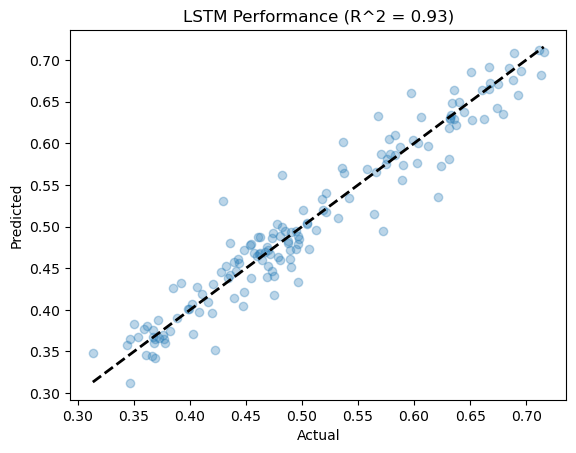

In [171]:
# Make predictions on the test data
test_pred = model.predict(X_test)

# Calculate R-squared
r2 = r2_score(y_test, test_pred)

# Create a scatter plot of actual vs predicted values
plt.scatter(y_test, test_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'LSTM Performance (R^2 = {r2:.2f})')
plt.show()

In [148]:
# Dự đoán cho tập huấn luyện và kiểm tra
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Hiển thị kết quả trước khi đảo ngược chuẩn hóa
print("Kết quả dự đoán trước khi đảo ngược (train):", train_predict[:5])
print("Kết quả dự đoán trước khi đảo ngược (test):", test_predict[:5])



20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Kết quả dự đoán trước khi đảo ngược (train): [[0.15912093]
 [0.15573986]
 [0.1726533 ]
 [0.17221445]
 [0.17775398]]
Kết quả dự đoán trước khi đảo ngược (test): [[0.60484123]
 [0.575557  ]
 [0.5725955 ]
 [0.62138313]
 [0.63483214]]


In [149]:
# Đảo ngược chuẩn hóa
train_predict_original = scaler.inverse_transform(train_predict)
y_train_orig = scaler.inverse_transform([y_train])
test_predict_original = scaler.inverse_transform(test_predict)
y_test_orig = scaler.inverse_transform([y_test])

# Hiển thị kết quả sau khi đảo ngược chuẩn hóa
print("Kết quả dự đoán sau khi đảo ngược (train):", train_predict_original[:5])
print("Kết quả dự đoán sau khi đảo ngược (test):", test_predict_original[:5])


Kết quả dự đoán sau khi đảo ngược (train): [[68.40544 ]
 [68.07451 ]
 [69.729965]
 [69.687004]
 [70.2292  ]]
Kết quả dự đoán sau khi đảo ngược (test): [[112.031654]
 [109.16537 ]
 [108.8755  ]
 [113.650734]
 [114.9671  ]]


In [150]:
# Đảo ngược chuẩn hóa các giá trị dự đoán và thực tế
train_predict_original = scaler.inverse_transform(train_predict)
test_predict_original = scaler.inverse_transform(test_predict)
y_train_orig = scaler.inverse_transform([y_train])
y_test_orig = scaler.inverse_transform([y_test])

# Tính toán MAE, MSE, RMSE cho tập huấn luyện và kiểm tra

# Training set
train_mae = mean_absolute_error(y_train_orig[0], train_predict_original)
train_mse = mean_squared_error(y_train_orig[0], train_predict_original)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train_orig[0], train_predict_original)

# Testing set
test_mae = mean_absolute_error(y_test_orig[0], test_predict_original)
test_mse = mean_squared_error(y_test_orig[0], test_predict_original)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test_orig[0], test_predict_original)

# In ra các kết quả cho tập huấn luyện và kiểm tra
print(f"Training MAE: {train_mae:.4f}")
print(f"Training MSE: {train_mse:.4f}")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Training R²: {train_r2:.4f}\n")

print(f"Testing MAE: {test_mae:.4f}")
print(f"Testing MSE: {test_mse:.4f}")
print(f"Testing RMSE: {test_rmse:.4f}")
print(f"Testing R²: {test_r2:.4f}")

Training MAE: 1.5225
Training MSE: 4.2292
Training RMSE: 2.0565
Training R²: 0.9950

Testing MAE: 1.9538
Testing MSE: 7.1086
Testing RMSE: 2.6662
Testing R²: 0.9279


In [151]:
# Dự đoán giá cho ngày mai
last_sequence = X_test[-1:]  # Lấy sequence cuối cùng
tomorrow_price_scaled = model.predict(last_sequence)

# Hiển thị kết quả trước khi đảo ngược chuẩn hóa
print(f"Trọng số): {tomorrow_price_scaled[0][0]:.4f}")

# Đảo ngược chuẩn hóa để có giá trị thực
tomorrow_price_original = scaler.inverse_transform(tomorrow_price_scaled)
print(f"Kết quả dự đoán ngày hôm sau: {tomorrow_price_original[0][0]:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Trọng số): 0.4802
Kết quả dự đoán ngày hôm sau: 99.83


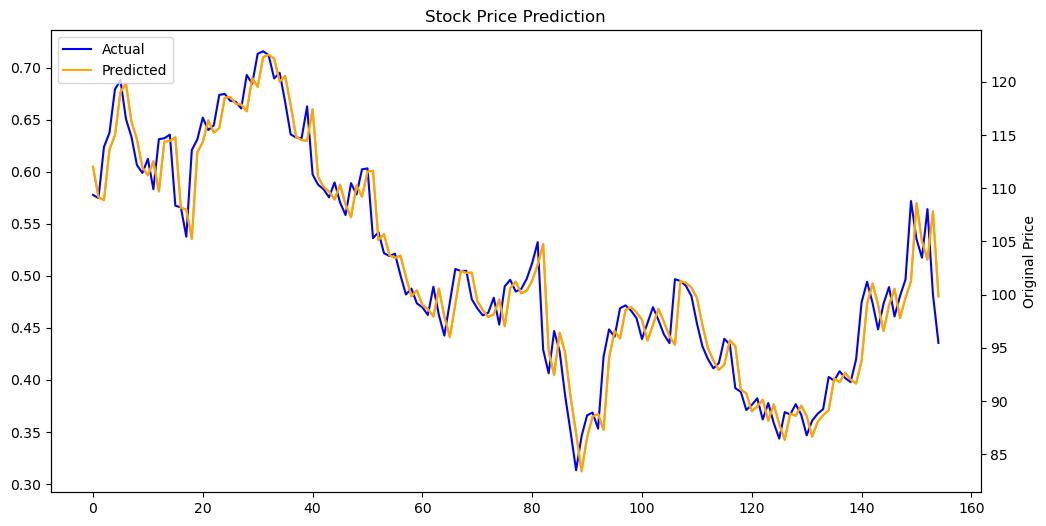

In [152]:
# Kích thước của biểu đồ
plt.figure(figsize=(12,6))

# Vẽ đường giá trị chuẩn hóa trên trục y chính
line1, = plt.plot(y_test, label='Actual', linestyle='-', color='blue')
line2, = plt.plot(test_predict, label='Predicted', linestyle='-', color='orange')

# Vẽ đường thực tế và dự đoán đã đảo ngược chuẩn hóa trên trục y phụ
ax2 = plt.twinx()  # Tạo trục y mới cho dữ liệu đã đảo ngược
line3 = ax2.plot(y_test_orig, label='Actual (original)', color='blue')  # Không có dấu phẩy sau line3
line4 = ax2.plot(test_predict_original, label='Predicted (original)', color='orange')  # Không có dấu phẩy sau line4

# Thiết lập tiêu đề và nhãn
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Normalized Price')  # Nhãn cho trục y chính (giá trị chuẩn hóa)
ax2.set_ylabel('Original Price')  # Nhãn cho trục y phụ (giá trị gốc đã đảo ngược chuẩn hóa)

# Tạo một chú thích duy nhất cho cả hai trục
# Cần hợp nhất danh sách các dòng từ cả hai trục y
lines = [line1, line2] + line3 + line4  # Kết hợp cả hai trục vào một danh sách
labels = [line.get_label() for line in [line1, line2]] 
plt.legend(lines, labels, loc='upper left')

# Hiển thị biểu đồ
plt.show()


In [153]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 1, 50)          │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,955 (359.20 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,304 (239.47 KB)